In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import functools
from IPython.display import Image, clear_output

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import tensorflow as tf
import pandas as pd
from data_info import *
from preprocessing_helpers import *
from datetime import datetime
%matplotlib inline
pd.set_option("display.precision", 2)
tf.random.set_seed(42)

In [2]:
new_cols = [LABEL_COLUMN] + CATEGORICAL_COLUMNS + [
                   'year',
                   'weekofyear',
                   'reanalysis_tdtr_k',
                   'station_diur_temp_rng_c',
                   'precipitation_amt_mm',] + [DATETIME_COLUMN]
new_cols_no_label = CATEGORICAL_COLUMNS + [
                   'year',
                   'weekofyear',
                   'reanalysis_tdtr_k',
                   'station_diur_temp_rng_c',
                   'precipitation_amt_mm',] + [DATETIME_COLUMN]
new_norm = [
                   'reanalysis_tdtr_k',
                   'station_diur_temp_rng_c',
                   'precipitation_amt_mm',
]

new_scale = [
                   'year',
                   'weekofyear',
]

extra_cols = [
]

In [3]:
datasets, norm_scale = generate_lstm_data(
    train_file, 
    single_step=True, 
    history_size=3, 
    cols=new_cols, 
    norm_cols=new_norm, 
    scale_cols=new_scale,
    extra_columns=extra_cols,
    train_frac=1.0
)
sj_train_x, sj_train_y = datasets[1][0]
len(sj_train_x)

516

In [4]:
(sj_train_x, sj_train_y) = datasets[0][0]
(iq_train_x, iq_train_y) = datasets[1][0]

In [7]:
len(sj_train_x.shape)

3

In [8]:
BATCH_SIZE = 8
BUFFER_SIZE = 500
train_sj_data_single = tf.data.Dataset.from_tensor_slices((sj_train_x, sj_train_y))
train_sj_data_single = train_sj_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat(10)

# val_sj_data_single = tf.data.Dataset.from_tensor_slices((sj_val_x, sj_val_y))
# val_sj_data_single = val_sj_data_single.batch(BATCH_SIZE).repeat()

In [15]:
# Build network with 
def build_model(optimizer = None):
  model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=sj_train_x.shape[-2:], go_backwards=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
  ])
  print(sj_train_x.shape[-2:])
  print(sj_train_x.shape)
  print(sj_train_x[0])

  if not optimizer:
    optimizer = tf.keras.optimizers.RMSprop()

  model.compile(loss='mae',
                optimizer=optimizer,
                metrics=['mae', 'accuracy'])
  return model


In [16]:
class BatchLossCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(BatchLossCallback, self).__init__()
        self.all_losses = []
    
    def on_epoch_end(self, epoch, logs=None):
        self.all_losses.append((epoch, logs['loss'], logs['mae'], logs['val_mae']))

In [17]:
log_dir="logs/fit/lstm" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# create model
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.01, nesterov=False, name='SGD')


# Train the Model.
EVALUATION_INTERVAL = 200
EPOCHS = 1

# The patience parameter is the amount of epochs to check for improvement
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=5, min_lr=1e-6, verbose=1,
#                                                      mode="max")
data_kfold = k_fold_data(sj_train_x, sj_train_y, folds=18)

losses = BatchLossCallback()

sj_model = build_model()
for train, test in data_kfold:
    train_sj_data_single = tf.data.Dataset.from_tensor_slices((sj_train_x[train], sj_train_y[train]))
    train_sj_data_single = train_sj_data_single.cache().batch(BATCH_SIZE).repeat()
    
    val_sj_data_single = tf.data.Dataset.from_tensor_slices((sj_train_x[test], sj_train_y[test]))
    val_sj_data_single = val_sj_data_single.batch(BATCH_SIZE).repeat()
    history = sj_model.fit(
        train_sj_data_single,
        epochs=EPOCHS, 
        steps_per_epoch=EVALUATION_INTERVAL,
        verbose=1,
        validation_data=val_sj_data_single,
        validation_steps=50,
        callbacks=[tensorboard_callback, losses])

(3, 5)
(932, 3, 5)
[[ 0.22967272  0.17492998 -0.51602232  0.          0.32692308]
 [-0.286815   -0.4579098  -0.28233798  0.          0.34615385]
 [-0.43028381 -0.32107957 -0.01899369  0.          0.36538462]]
Train for 200 steps, validate for 50 steps
200/200 [==============================] - 3s 15ms/step - loss: 30.2519 - mae: 30.2519 - accuracy: 0.0113 - val_loss: 20.4054 - val_mae: 21.3466 - val_accuracy: 0.0000e+00
Train for 200 steps, validate for 50 steps
 75/200 [==========>...................] - ETA: 1s - loss: 29.8224 - mae: 29.8224 - accuracy: 0.0100

KeyError: 'val_mae'

In [17]:
mean_err = 0
global_max = {
    'train': 1,
    'epoch': 1,
    'mae': 100000,
}
for i in range(1, int(len(losses.all_losses)/EPOCHS)):
    train_history = losses.all_losses[(i-1)*EPOCHS:i*EPOCHS]
    min_val = 100000
    for row in train_history:
        epoch, loss, mae, val_loss = row
#         print(val_loss)
        if val_loss < min_val:
            min_val = val_loss
        if val_loss < global_max['mae']:
            global_max = {
                'train': i,
                'epoch': epoch,
                'mae': val_loss
            }
    mean_err += min_val / (len(losses.all_losses)/EPOCHS)
    
print(mean_err)
print(global_max)

22.54943879445394
{'train': 7, 'epoch': 0, 'mae': 12.460173}


In [1]:
org_test_data, test_scale = generate_lstm_data(
    test_file, history_size=3, 
    cols=new_cols_no_label, norm_cols=new_norm, 
    scale_cols=new_scale, single_step=True, 
    train_frac=1.0, train_scale=norm_scale, 
    prepend_with_file=train_file,
    extra_columns=extra_cols
)
(sj_test_x, sj_test_y), = org_test_data[0]
(iq_test_x, iq_test_y), = org_test_data[1]
# print(sj_test_x)
# val_set = tf.data.Dataset.from_tensor_slices((sj_val_x, sj_val_y))
# sj_test_set = val_set.concatenate(tf.data.Dataset.from_tensor_slices((sj_test_x, sj_test_y))).batch(1 + len(sj_val_y))
sj_test_set = tf.data.Dataset.from_tensor_slices((sj_test_x, sj_test_y)).batch(len(sj_test_y))

# print(sj_test_x[0])
print(len(sj_test_y))
# print(sj_val_y)
# print(sj_val_x[0])
sj_pred = []
for x, y in sj_test_set.take(1):
#     print(x)
    predictions = sj_model.predict(x)
    sj_pred = predictions.flatten()
    print(len(predictions.flatten()))
# test_predictions = model.predict(org_test_data).flatten()

NameError: name 'generate_lstm_data' is not defined

In [19]:
train_iq_data_single = tf.data.Dataset.from_tensor_slices((iq_train_x, iq_train_y))
train_iq_data_single = train_iq_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# val_iq_data_single = tf.data.Dataset.from_tensor_slices((iq_val_x, iq_val_y))
# val_iq_data_single = val_iq_data_single.batch(BATCH_SIZE).repeat()
EPOCHS = 1
losses = BatchLossCallback()
data_kfold = k_fold_data(iq_train_x, iq_train_y)
iq_model = build_model()
for train, test in data_kfold:
    print(len(train))
    print(len(iq_train_x[0]))
    train_iq_data_single = tf.data.Dataset.from_tensor_slices((iq_train_x[train], iq_train_y[train]))
    train_iq_data_single = train_iq_data_single.cache().batch(BATCH_SIZE).repeat()
    
    val_iq_data_single = tf.data.Dataset.from_tensor_slices((iq_train_x[test], iq_train_y[test]))
    val_iq_data_single = val_iq_data_single.batch(BATCH_SIZE).repeat()

    history = iq_model.fit(
        train_iq_data_single,
        epochs=EPOCHS, 
        steps_per_epoch=EVALUATION_INTERVAL,
        verbose=1,
        validation_data = val_iq_data_single, 
        validation_steps=50,
        callbacks=[tensorboard_callback, losses])

464
3
Train for 200 steps, validate for 50 steps
200/200 [==============================] - 3s 15ms/step - loss: 6.2866 - mae: 6.2866 - accuracy: 0.1106 - val_loss: 4.7070 - val_mae: 4.8781 - val_accuracy: 0.0995
464
3
Train for 200 steps, validate for 50 steps
200/200 [==============================] - 2s 9ms/step - loss: 5.9504 - mae: 5.9504 - accuracy: 0.0913 - val_loss: 6.1287 - val_mae: 6.4707 - val_accuracy: 0.1129
464
3
Train for 200 steps, validate for 50 steps
200/200 [==============================] - 2s 10ms/step - loss: 6.1439 - mae: 6.1439 - accuracy: 0.1013 - val_loss: 4.1107 - val_mae: 4.0230 - val_accuracy: 0.0565
464
3
Train for 200 steps, validate for 50 steps
200/200 [==============================] - 2s 10ms/step - loss: 5.8461 - mae: 5.8461 - accuracy: 0.1006 - val_loss: 6.2219 - val_mae: 6.4238 - val_accuracy: 0.1210
464
3
Train for 200 steps, validate for 50 steps
200/200 [==============================] - 2s 10ms/step - loss: 5.7384 - mae: 5.7384 - accuracy: 0.1

In [20]:
mean_err = 0
global_max = {
    'train': 1,
    'epoch': 1,
    'mae': 100000,
}
for i in range(1, int(len(losses.all_losses)/EPOCHS)):
    train_history = losses.all_losses[(i-1)*EPOCHS:i*EPOCHS]
    min_val = 100000
    for row in train_history:
        epoch, loss, mae, val_loss = row
#         print(val_loss)
        if val_loss < min_val:
            min_val = val_loss
        if val_loss < global_max['mae']:
            global_max = {
                'train': i,
                'epoch': epoch,
                'mae': val_loss
            }
    mean_err += min_val / (len(losses.all_losses)/EPOCHS)
    
print(mean_err)
print(global_max)

5.373705959320068
{'train': 3, 'epoch': 0, 'mae': 4.0230436}


In [21]:
iq_test_set = tf.data.Dataset.from_tensor_slices((iq_test_x, iq_test_y)).batch(len(iq_test_y))
print(len(iq_test_y))
iq_pred = []
for x, y in iq_test_set.take(1):
    print(len(x))
    predictions = iq_model.predict(x)
    iq_pred = predictions.flatten()
    print(len(predictions.flatten()))
    
# print(pred)
# print(len(pred))

520
520
520


In [22]:
from preprocessing_helpers import export_test_to_csv
preds = np.concatenate((sj_pred, iq_pred), axis=None)
export_test_to_csv(predictions=preds,path=train_file)

1456
asas


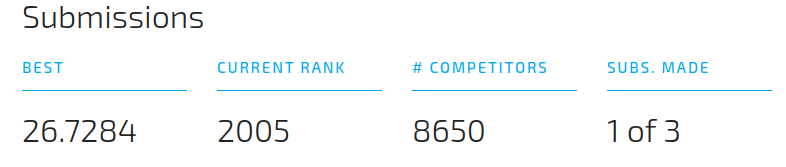

In [154]:
#Current Ranking (baseline)
Image("img/current-30-03.png")

In [77]:
# Tensorboard
# https://tensorboard.dev/experiment/rsdMubj0S165iOdLmbd13A/#scalars